# Intel MPI Benchmarks

Results of selected MPI1 tests from the [IMB benchmark suite](https://software.intel.com/content/www/us/en/develop/documentation/imb-user-guide/top.html).

All tests use two nodes:
- pingpong: Single process per node
- uniband: Multiple processes per node, communicating in pairs split between 1st and 2nd half of ranks
- biband: As for uniband but communication initiated in both directions

Tests use a range of message sizes and report bandwidth and/or latency.

In [1]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../reframe', '..')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Bandwidth/latency vs message size

The plots below show results vs message size for tests using a single process per node. Results are for the most-recent test on each system/partition/environment combination.

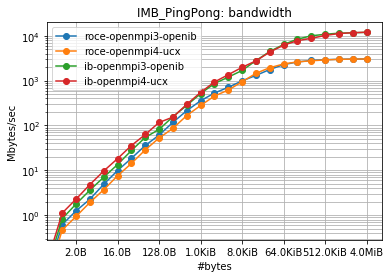

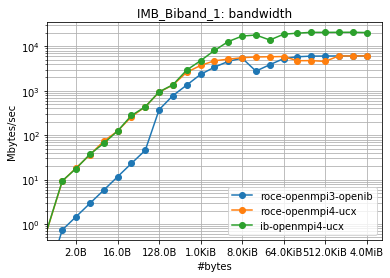

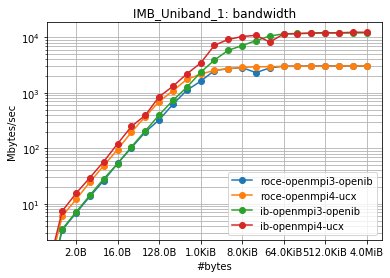

In [3]:
for test in ['IMB_PingPong', 'IMB_Biband_1', 'IMB_Uniband_1']:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../output', test=test)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    common, meta_diffs = modules.utils.diff_dicts([modules.utils.parse_path_metadata(p) for p in paths], ignore=['path'])
    
    # load and plot:
    for ix, path in enumerate(paths):
        data = modules.imb.read_imb_out(path)
        label = '-'.join(meta_diffs[ix].values())
        plt.plot(data['#bytes'], data['Mbytes/sec'], 'o-', data=data, label=label)
    # TODO: need to add latency plots for IMB_PingPong
        
    # format plot:
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
    ax.grid(True, which="both")
    ax.set_xlabel('#bytes')
    ax.set_ylabel('Mbytes/sec')
    title = ' '.join(['%s:%s' % (k, v) for (k, v) in common.items()]) # TODO: improve
    ax.set_title('%s: bandwidth' % (test))
    ax.legend()

# Max Bandwidth vs Number of Processes per Node

The plots below show the **maximum** bandwidth for tests using varying numbers of processes per node. Results are for the most-recent test on each system/partition/environment combination.

IMB_Uniband_*: max_bandwidth (Mbytes/sec)


case,alaska-ib-openmpi3-openib-imb,alaska-ib-openmpi4-ucx-imb,alaska-roce-openmpi3-openib-imb,alaska-roce-openmpi4-ucx-imb
procs_per_node,,,,
1,12067.84,12354.04,3060.48,3062.84
2,12315.77,12378.71,11104.47,11270.47
4,21940.35,21757.44,20973.67,20508.94
8,42051.32,41768.63,42705.33,40707.94
16,86001.52,72394.82,79121.01,77348.36
32,153550.76,113473.41,156536.66,142076.50
64,163330.48,117146.55,164547.87,123220.89


IMB_Biband_*: max_bandwidth (Mbytes/sec)


case,alaska-ib-openmpi4-ucx-imb,alaska-roce-openmpi3-openib-imb,alaska-roce-openmpi4-ucx-imb
procs_per_node,,,
1,20814.16,6112.22,6113.15
2,20649.39,17164.64,19718.69
4,39534.72,36427.25,35413.61
8,73750.42,66475.29,71775.41
16,138313.77,128965.75,135945.08
32,232777.77,177402.50,260862.22
64,261103.76,248771.29,178372.98


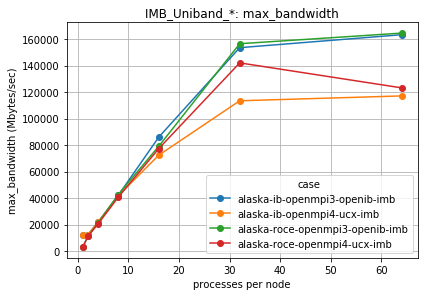

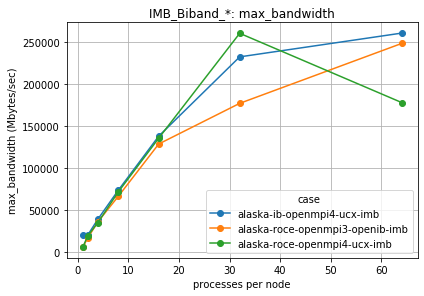

In [5]:
for test in ['IMB_Uniband_*', 'IMB_Biband_*']:
    
    # load perf records:
    perf_records = modules.utils.load_perf_logs('../perflogs', test, '.log')
    
    # calculate number of processes (=tasks):
    perf_records['procs_per_node'] = [int(tn.rsplit('_')[-1]) for tn in perf_records['testname']]
    
    # plot/tabulate:
    for perf_var in ['max_bandwidth']:
        perf_unit = perf_records[perf_records['perf_var'] == perf_var]['perf_unit'].iloc[0] # assumes unique
        table = modules.plots.tabulate_last_perf_vs(perf_records, 'procs_per_node', perf_var)
        ax = table.plot(grid=True, style='o-')
        ax.set_xlabel('processes per node')
        ax.set_ylabel('%s (%s)' % (perf_var, perf_unit))
        plt.tight_layout()
        ax.set_title('%s: %s' % (test, perf_var))
        
        print('%s: %s (%s)' % (test, perf_var, perf_unit))
        display(HTML(table.to_html()))
